In [47]:
%reset -f

In [48]:
import gc
import numpy as np
from itertools import islice
from collections import Counter
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
gc.collect()

0

In [49]:
with open('./dataset/corpus', 'rt') as fp:
    corpus = fp.read()

corpus = corpus.strip()
corpus = corpus.split()[:3000]
print(len(corpus))

3000


In [50]:
class SkipGramBatcher:
    def __init__(self, corpus, window_size=4, batch_size=32):
        '''corpus - list of words'''
        self.corpus = corpus
        self.window_size = window_size
        self.batch_size = batch_size
        self.make_vocab()
        return
    
    def make_vocab(self):
        self.vocab = sorted(set(corpus))
        self.V = len(self.vocab)
        self.word2index = {w: idx for idx, w in enumerate(self.vocab)}
        self.index2word = {idx: w for idx, w in enumerate(self.vocab)}
        return
    
    def batch_gen(self):
        '''c - corpus, v - vocab ; i - central, j - side'''
        x_batch = np.empty(self.batch_size, dtype=np.int)
        y_batch = np.empty(self.batch_size, dtype=np.int)
        curr_idx = 0
        for c_i, w in enumerate(self.corpus):
            v_i = self.word2index[w]
            window_left_border = c_i - self.window_size
            if window_left_border < 0:
                window_left_border = 0
            for side_w in self.corpus[window_left_border: c_i] \
                          + self.corpus[c_i + 1 : c_i + self.window_size + 1]:
                v_j = self.word2index[side_w]
                x_batch[curr_idx] = v_i
                y_batch[curr_idx] = v_j
                curr_idx += 1
                if curr_idx == self.batch_size:
                    curr_idx = 0
                    yield (x_batch, y_batch)
        # drop last
        #if curr_idx != 0:
            #yield (x_batch, y_batch)

In [51]:
def freq_filter(corpus, threshold):
    freq_map = Counter(corpus)
    filtrator = lambda w: 'UNK' if freq_map[w] <= threshold else w
    corpus = map(filtrator, corpus)
    return list(corpus)

In [52]:
#corpus = freq_filter(corpus, 1)
#corpus.count('UNK') / len(corpus)

In [53]:
def w2v_forward(x, w):
    '''x - (batch_size x V) ohe batch to forward through
       w - (V x N) weight matrix'''
    V, N = w.shape
    batch_size = x.shape[0]
    h = x.mm(w)
    assert(h.shape == (batch_size, N))
    
    scores = h.mm(w.transpose(0, 1))
    assert(scores.shape == (batch_size, V))
    
    proba = torch.nn.functional.log_softmax(scores, dim=1)
    assert(proba.shape == (batch_size, V))
    
    return proba

def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, dtype=torch.float32) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

In [54]:
batcher = SkipGramBatcher(corpus, batch_size=16)

In [55]:
V = batcher.V
N = 300
learning_rate = 1
print(V)
print(N)

984
300


In [56]:
w = random_weight((V, N))

In [57]:
optimizer = torch.optim.SGD([w], lr=learning_rate)

In [58]:
print_every = 1

In [59]:
def train(w, optimizer, epochs=1):
    """    
    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    """
    loss_values = []
    for e in range(epochs):
        
        loader_train = batcher.batch_gen()
        batch_size = batcher.batch_size
        epoch_loss = 0
        
        for t, (x_ids, y_ids) in enumerate(loader_train):
            
            input_buff = np.zeros((batch_size, V), dtype=np.float32)
            input_buff[np.arange(batch_size), x_ids] = 1

            x = torch.from_numpy(input_buff)
            y = torch.from_numpy(y_ids)

            scores = w2v_forward(x, w)
            loss = torch.nn.functional.nll_loss(scores, y)
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if t % print_every == 0:
                #print('e: %d | batch: %d, loss = %.9f' % (e, t, loss.item())) # batch loss
                pass
        loss_values.append(epoch_loss)
        print('e: %d | loss = %.9f' % (e, epoch_loss))
    return loss_values

In [60]:
loss_values = train(w, optimizer, epochs=16)

e: 0 | loss = 9191.109447002
e: 1 | loss = 8263.695015430
e: 2 | loss = 7587.739451647
e: 3 | loss = 7314.100595474
e: 4 | loss = 7269.107390642
e: 5 | loss = 7246.743280411
e: 6 | loss = 7234.219536781
e: 7 | loss = 7225.380639076
e: 8 | loss = 7219.608383179
e: 9 | loss = 7215.403663397
e: 10 | loss = 7212.450559378
e: 11 | loss = 7210.236490250
e: 12 | loss = 7208.608213902
e: 13 | loss = 7207.354713917
e: 14 | loss = 7206.401748657
e: 15 | loss = 7205.653502226


It took less than a minute to train.

In [61]:
def plot_metric(x, y):
    plt.figure(figsize=(16, 8))
    plt.plot(x, y, 'o-', label='train')
    plt.xlabel('epochs')
    plt.ylabel('nll_loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

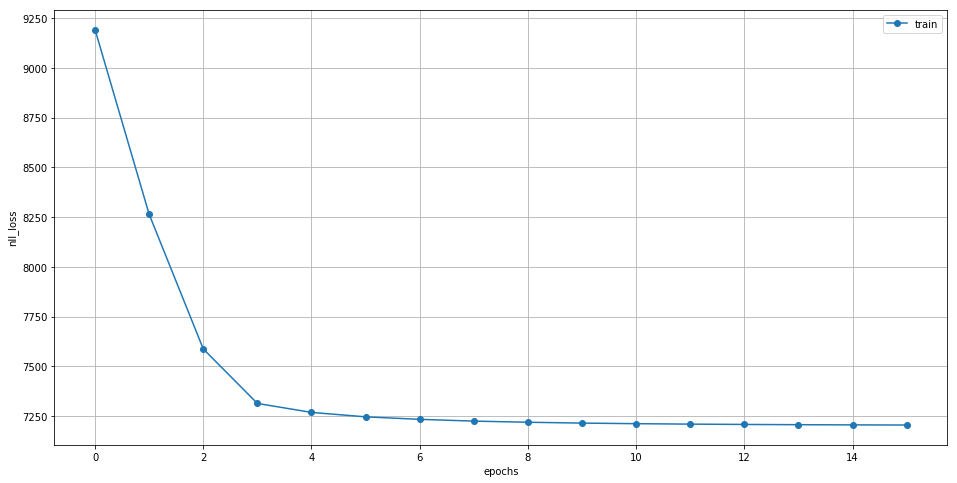

In [62]:
plot_metric(range(len(loss_values)), loss_values)

In [63]:
W = w.data.numpy()

In [64]:
def get_word_vector(token):
    '''function to map token to corresponding word vector'''
    idx = batcher.word2index[token]
    return W[idx]

### Plot vector progections of 50 most frequent words (beautiful visualization)

In [65]:
def reduce_to_k_dim(M, k=2):
    n_iter = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iter)
    M_reduced = svd.fit_transform(M)
    
    print("Done.")
    return M_reduced

In [66]:
W_reduced = reduce_to_k_dim(W)

Running Truncated SVD over 984 words...
Done.


In [72]:
def plot_embeddings(M_reduced, word2Ind, words):
    plt.figure(figsize=(10, 16))
    for w in words:
        idx = word2Ind[w]
        x, y = M_reduced[idx]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, w, fontsize=11)
    ax = plt.gca()
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    plt.grid()
    plt.show()

In [68]:
freq_map = Counter(corpus)
most_freq_words = sorted(freq_map.items(), key=lambda x: x[-1], reverse=True)
most_freq_words = list(zip(*most_freq_words))[0]

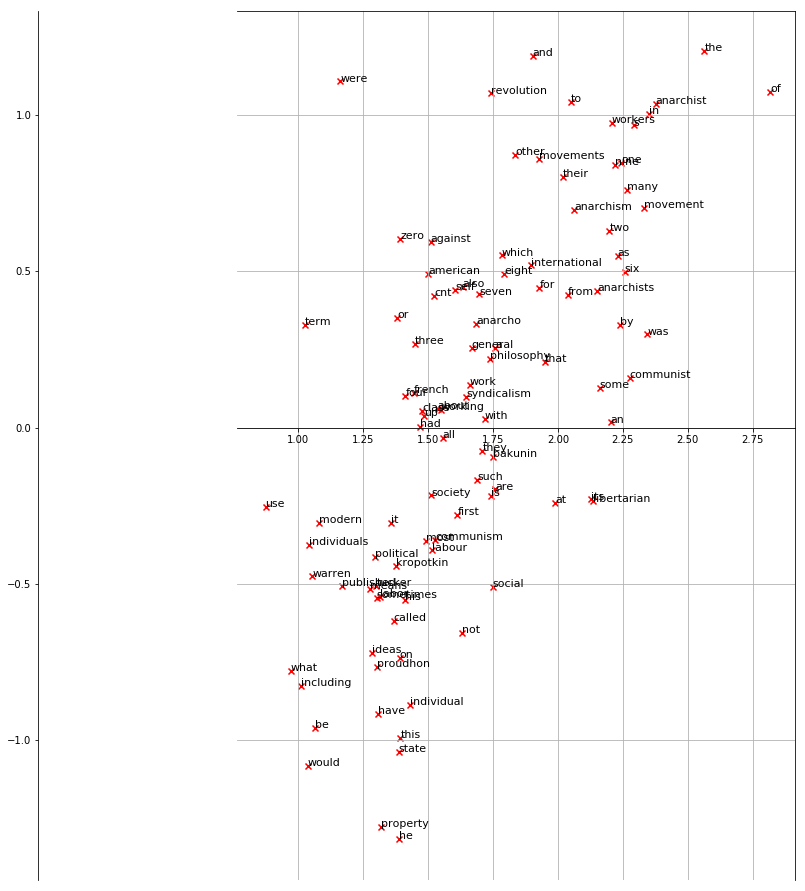

In [73]:
plot_embeddings(W_reduced, batcher.word2index, most_freq_words[:100])

### qualitative evaluations of word vectors: nearest neighbors, word analogies

In [90]:
def top_similar(token, n_similar):
    sim_matrix = cosine_similarity(W)
    idx = batcher.word2index['revolution']
    most_similar = list( np.argsort(sim_matrix[idx])[::-1] )
    most_similar.remove(idx)
    for w in [batcher.index2word[i] for i in most_similar[:n_similar]]:
        print(w)

In [91]:
top_similar('revolution', 30)

october
bolsheviks
movements
one
their
russian
nine
resulting
both
against
of
in
civil
kronstadt
other
france
war
bolshevism
many
s
eight
two
self
cgt
anarchism
the
six
was
to
february


In [92]:
def solve_analogy(positive, negative, n_similar):
    pos_vec = [get_word_vector(w) for w in positive]
    neg_vec = [get_word_vector(w) for w in negative]

    vec = np.zeros(pos_vec[0].size)
    for v in pos_vec:
        vec += v
    for v in neg_vec:
        vec -= v
        
    sim_matrix = cosine_similarity(vec[np.newaxis, :] , W)
    most_similar = list(np.argsort(sim_matrix[0])[::-1])
    
    for w in positive + negative:
        most_similar.remove(batcher.word2index[w])
        
    for w in [batcher.index2word[i] for i in most_similar if len(batcher.index2word[i]) > 3][:n_similar]:
        print(w)

### a / b = x / y

In [83]:
a = 'anarchists'
b = 'chaos'
x = 'radicals'

In [84]:
positive = [x, b]
negative = [a]

anarchists : chaos :: radicals : anomie (mean)

In [93]:
solve_analogy(positive, negative, 20)

mean
something
anomie
louis
armand
still
nihilism
term
anarchiste
imply
harmonious
works
class
rather
baron
working
developed
politics
communistic
culottes
